In [1]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

Welcome to JupyROOT 6.30/02


In [2]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            #print(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            #eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            #eff_error.append((jsonFile['output_parameters']['efficiencyMuon_corrected']*(1-jsonFile['output_parameters']['efficiencyMuon_corrected'])/1000)**0.5)
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [3]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        if (int(scanIds[scanId][0])==5810) or (int(scanIds[scanId][0])==5805) or (int(scanIds[scanId][0])==5820) or (int(scanIds[scanId][0])==5826) or (int(scanIds[scanId][0])==5830) or (int(scanIds[scanId][0])==5827) or (int(scanIds[scanId][0])==5815) or (int(scanIds[scanId][0])==5811):    
            N = "7"
        if (int(scanIds[scanId][0])==5841)or (int(scanIds[scanId][0])==5838) or (int(scanIds[scanId][0])==5840):
            N = "8"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [4]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)
sigmoid21 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid21.SetParNames("Emax","Lambda","HV50")
sigmoid21.SetParameters(0.9, 0.001, 7000)
sigmoid22 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid22.SetParNames("Emax","Lambda","HV50")
sigmoid22.SetParameters(0.9, 0.001, 7000)

In [5]:
scans = {'30CO2_OFF': ['5627'],
         '30CO2_22':  ['5659'],
         '30CO2_10':  ['5675'],
         '30CO2_6.9': ['5621'],
         '30CO2_4.6': ['5623'],
         '30CO2_3.3': ['5622', '5625'],
         '30CO2_2.2': ['5827'],
         '30CO2_1': ['5820'],
         '30CO205SF6_OFF': ['5712'],
         '30CO205SF6_22':  ['5706'],
         '30CO205SF6_10':  ['5707'],
         '30CO205SF6_6.9': ['5708'],
         '30CO205SF6_4.6': ['5709'],
         '30CO205SF6_3.3': ['5713'],
         '30CO205SF6_2.2': ['5840'],
         '30CO205SF6_1': ['5838'],
         '40CO2_OFF': ['5612'],
         '40CO2_22':  ['5615'],
         '40CO2_10':  ['5614'],
         '40CO2_6.9': ['5616'],
         '40CO2_4.6': ['5613'],
         '40CO2_3.3': ['5611'],
         'STDMX_OFF': ['5809'],
         'STDMX_22':  ['5632'],
         'STDMX_10':  ['5631'],
         'STDMX_6.9': ['5633'],
         'STDMX_4.6': ['5630'],
         'STDMX_3.3': ['5629'],
         'STDMX_2.2': ['5805'],
         'STDMX_1': ['5810']
         }

Scans_STDMX = {'STDMX_OFF': ['5808'],
         'STDMX_22':  ['5813'],
         'STDMX_10':  ['5815'], #HV7
         'STDMX_6.9': ['5811'], #HV7 
         'STDMX_4.6': ['5807'],
         'STDMX_3.3': ['5814'],
         'STDMX_2.2': ['5805'], #HV7
         'STDMX_1': ['5810'], #HV7
         }

scans_STDMX = [
         ['STDMX_OFF', sigmoid1, 6, 23],
         ['STDMX_22', sigmoid2, 6, 23],
         ['STDMX_10', sigmoid3, 3, 22],
         ['STDMX_6.9', sigmoid4, 6, 23],
         ['STDMX_4.6', sigmoid5, 6, 23],
         ['STDMX_3.3', sigmoid6, 1, 34],
         ['STDMX_2.2', sigmoid7, 2, 20],
         ['STDMX_1', sigmoid8, 4, 21],
         ]

In [6]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 
    HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0   6000.0  6000.0     0.000000     0.000000     0.000000      0.000000   
1   6100.0  6100.0     0.000000     0.000000     0.000000      0.000000   
2   6200.0  6200.0     0.000000     0.000000     0.000000      0.000000   
3   6300.0  6300.0     0.000000     0.000000     0.000000      0.000000   
4   6400.0  6400.0     0.000000     0.000000     0.000487      0.000000   
5   6500.0  6500.0     0.000000     0.000000     0.000741      0.000000   
6   6600.0  6600.0     0.000000     0.000000     0.001627      0.000000   
7   6700.0  6700.0     0.000000     0.000000     0.001906      0.000000   
8   6800.0  6800.0     0.000000     0.000000     0.002213      0.000000   
9   6900.0  6900.0     0.000000     0.000000     0.006078      0.000000   
10  7000.0  7000.0     0.002920     0.000000     0.005998      0.000050   
11  7100.0  7100.0     0.006515     0.004235     0.007647      0.000000   
12  7200.0  

# Analise de STDMX

In [7]:
Features_STDMX = FeaturesDataFrame(Scans_STDMX)
Features_STDMX['gamma_CM'][0] = 1
Features_STDMX['gamma_CS'][0] = 1
Features_STDMX['noiseGammaRate'][0] = 1
print("Features_STDMX = ", Features_STDMX)
Features_STDMX

scanID:  5808
scanID:  5813
scanID:  5815
scanID:  5811
scanID:  5807
scanID:  5814
scanID:  5805
scanID:  5810
Features_STDMX =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.662577     0.579678  7250.0  7250.0     0.021638      0.000510   
1     7.331106     6.235990  7250.0  7250.0     0.020339      0.009124   
2    12.528288    10.652905  7200.0  7200.0     0.013554      0.013070   
3    18.163424    15.603424  7200.0  7200.0     0.018294      0.017172   
4    25.579945    21.916266  7250.0  7250.0     0.020301      0.028520   
5    38.579806    33.307197  7250.0  7250.0     0.016467      0.040073   
6    45.416834    38.666666  7200.0  7200.0     0.012144      0.035533   
7    86.239032    73.963387  7200.0  7200.0     0.008774      0.050569   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.056347   1.000000  2.149189  1.000000     0.128334      0.049051   
1  1.077327   1.858821  2.120928  1.854984     0.120509  

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.662577,0.579678,7250.0,7250.0,0.021638,0.000510,1.056347,1.000000,2.149189,1.000000,0.128334,0.049051,0.232817,0.037743,98.604936,0.000838,1.000000,2.257067,1.242255
1,7.331106,6.235990,7250.0,7250.0,0.020339,0.009124,1.077327,1.858821,2.120928,1.854984,0.120509,0.141672,0.213376,0.131367,96.817526,0.001771,252.046840,15.871513,13.567095
2,12.528288,10.652905,7200.0,7200.0,0.013554,0.013070,1.087038,2.808565,1.918211,1.726102,0.102617,0.183007,0.165461,0.105593,97.229975,0.002333,443.252216,21.047275,23.181193
3,18.163424,15.603424,7200.0,7200.0,0.018294,0.017172,1.114041,3.925548,1.886551,1.711130,0.107135,0.257984,0.165510,0.105519,96.750063,0.002524,652.265160,25.531975,33.766847
4,25.579945,21.916266,7250.0,7250.0,0.020301,0.028520,1.138434,5.301146,2.017176,1.784251,0.113382,0.372206,0.182703,0.117058,96.530672,0.001482,934.880286,30.566492,47.496211
5,38.579806,33.307197,7250.0,7250.0,0.016467,0.040073,1.190779,8.088920,1.989675,1.750194,0.114043,0.550905,0.173901,0.111598,95.672184,0.002050,1405.879286,37.484303,71.887003
6,45.416834,38.666666,7200.0,7200.0,0.012144,0.035533,1.204696,10.107134,1.750532,1.629212,0.093490,0.593147,0.126066,0.090312,94.331049,0.003283,1636.756207,40.444366,84.083500
7,86.239032,73.963387,7200.0,7200.0,0.008774,0.050569,1.339684,20.048940,1.671138,1.542672,0.080970,1.052406,0.095246,0.076939,92.809289,0.003664,3072.646371,55.412495,160.202420


Total de scans no dicionário: 8
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.01216180708246331
HV95_err = 3.7603528229451637
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010335318171727925
HV95_err = 3.278368380127679
Fit concluído para o scan: STDMX_22
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010579609411315853
HV95_err = 3.062315569430728
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.010735282779421502
HV95_err = 3.2360435167002364
Fit concluído para o scan: STDMX_6.9
Processando scan: STDMX_4.6
scanId =  5630
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010336938454391894
HV95_err = 3.464146085468082
Fit concluído para o scan: STDMX_4.6
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.01056025004644915
HV95_err 

Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6070 xmax = 7630 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6070.000000,7630.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::B

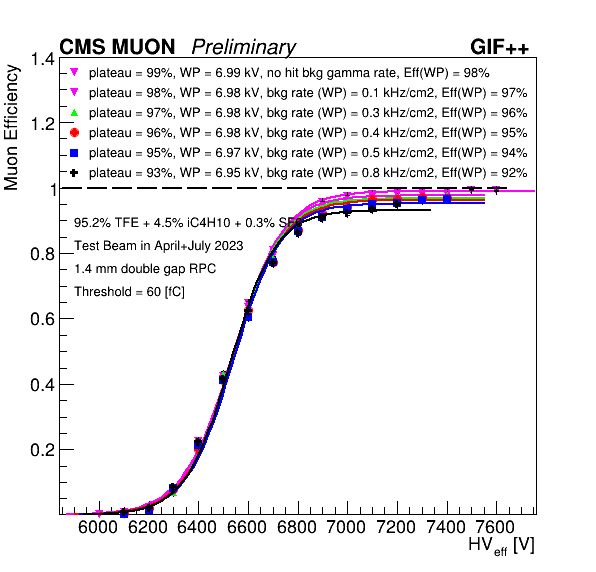

In [8]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

# Cores e estilos de marcadores
colors = [1, 2, 4, 6, 8, 9, 11]  # Preto, Vermelho, Azul, Laranja, Rosa, Verde, Amarelo
markers = [20, 21, 22, 23, 24, 25, 26]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_STDMX):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_OFF = Features_STDMX['noiseGammaRate'][0] / (Features_STDMX['gamma_CS'][0] * 1000)
    txt_STDMX_22 = Features_STDMX['noiseGammaRate'][1] / (Features_STDMX['gamma_CS'][1] * 1000)
    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    txt_STDMX_6_9 = Features_STDMX['noiseGammaRate'][3] / (Features_STDMX['gamma_CS'][3] * 1000)
    txt_STDMX_4_6 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][4] * 1000) 
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][5] / (Features_STDMX['gamma_CS'][5] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][6] / (Features_STDMX['gamma_CS'][6] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][7] / (Features_STDMX['gamma_CS'][7] * 1000)

     # Source OFF
    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., 
                                                                                                        c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    # Source 22
    eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., 
                                                                                                                  c=(func_list_STDMX[1].Eval(WP_STDMX[1])), 
                                                                                                                  d=txt_STDMX_22)
    # Source 10
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., 
                                                                                                                  c=(func_list_STDMX[2].Eval(WP_STDMX[2])), 
                                                                                                                  d=txt_STDMX_10)
    # Source 6.9
    eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., 
                                                                                                                  c=(func_list_STDMX[3].Eval(WP_STDMX[3])), 
                                                                                                                  d=txt_STDMX_6_9)
    # Source 4.6
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., 
                                                                                                                  c=(func_list_STDMX[4].Eval(WP_STDMX[4])), 
                                                                                                                  d=txt_STDMX_4_6)
    # Source 3.3
    eff_6_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[5], b=WP_STDMX[5] / 1000., 
                                                                                                                  c=(func_list_STDMX[5].Eval(WP_STDMX[5])), 
                                                                                                                  d=txt_STDMX_3_3)
    # Source 2.2
    eff_7_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[6], b=WP_STDMX[6] / 1000., 
                                                                                                                  c=(func_list_STDMX[6].Eval(WP_STDMX[6])), 
                                                                                                                  d=txt_STDMX_2_2)
    # Source 1
    eff_8_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[7], b=WP_STDMX[7] / 1000., 
                                                                                                                  c=(func_list_STDMX[7].Eval(WP_STDMX[7])), 
                                                                                                                  d=txt_STDMX_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "Standard Mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.67, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "p")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[5], eff_6_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[6], eff_7_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[7], eff_8_STDMX, "p")  # Bolinha azul


    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("STDMX_eff.png")
canvas_all.SaveAs("STDMX_eff.pdf")
canvas_all.SaveAs("STDMX_eff.root")

# Analise da mistura 30%CO2 + 1% SF6

In [9]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [10]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            #print(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            #eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            #eff_error.append((jsonFile['output_parameters']['efficiencyMuon_corrected']*(1-jsonFile['output_parameters']['efficiencyMuon_corrected'])/1000)**0.5)
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [11]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        if (int(scanIds[scanId][0])==5810) or (int(scanIds[scanId][0])==5805) or (int(scanIds[scanId][0])==5820) or (int(scanIds[scanId][0])==5826) or (int(scanIds[scanId][0])==5830) or (int(scanIds[scanId][0])==5827) or (int(scanIds[scanId][0])==5815) or (int(scanIds[scanId][0])==5811):    
            N = "7"
        if (int(scanIds[scanId][0])==5841)or (int(scanIds[scanId][0])==5838) or (int(scanIds[scanId][0])==5840):
            N = "8"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [12]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)
sigmoid21 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid21.SetParNames("Emax","Lambda","HV50")
sigmoid21.SetParameters(0.9, 0.001, 7000)
sigmoid22 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid22.SetParNames("Emax","Lambda","HV50")
sigmoid22.SetParameters(0.9, 0.001, 7000)

In [13]:
scans = {'30CO2_OFF': ['5627'],
         '30CO2_22':  ['5659'],
         '30CO2_10':  ['5675'],
         '30CO2_6.9': ['5621'],
         '30CO2_4.6': ['5623'],
         '30CO2_3.3': ['5622', '5625'],
         '30CO2_2.2': ['5827'],
         '30CO2_1': ['5820'],
         '30CO205SF6_OFF': ['5712'],
         '30CO205SF6_22':  ['5706'],
         '30CO205SF6_10':  ['5707'],
         '30CO205SF6_6.9': ['5708'],
         '30CO205SF6_4.6': ['5709'],
         '30CO205SF6_3.3': ['5713'],
         '30CO205SF6_2.2': ['5840'],
         '30CO205SF6_1': ['5838'],
         '40CO2_OFF': ['5612'],
         '40CO2_22':  ['5615'],
         '40CO2_10':  ['5614'],
         '40CO2_6.9': ['5616'],
         '40CO2_4.6': ['5613'],
         '40CO2_3.3': ['5611'],
         'STDMX_OFF': ['5809'],
         'STDMX_22':  ['5632'],
         'STDMX_10':  ['5631'],
         'STDMX_6.9': ['5633'],
         'STDMX_4.6': ['5630'],
         'STDMX_3.3': ['5629'],
         'STDMX_2.2': ['5805'],
         'STDMX_1': ['5810']
         }
Scans_30CO2 = {'30CO2_OFF': ['5819'],
         '30CO2_22':  ['5826'],
         '30CO2_10':  ['5832'], #HV7
         '30CO2_6.9': ['5830'], #HV7
         '30CO2_4.6': ['5831'],
         '30CO2_3.3': ['5822'],
         '30CO2_2.2': ['5827'], #HV7
         '30CO2_1': ['5820'] #HV7
         }
scans_30CO2 = [
         ['30CO2_OFF', sigmoid1, 6, 23],
         ['30CO2_22', sigmoid2, 6, 23],
         ['30CO2_10', sigmoid3, 3, 22],
         ['30CO2_6.9', sigmoid4, 6, 23],
         ['30CO2_4.6', sigmoid5, 6, 23],
         ['30CO2_3.3', sigmoid6, 1, 34],
         ['30CO2_2.2', sigmoid7, 2, 20],
         ['30CO2_1', sigmoid8, 4, 21],
         ]

In [14]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 
    HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0   6000.0  6000.0     0.000000     0.000000     0.000000      0.000000   
1   6100.0  6100.0     0.000000     0.000000     0.000000      0.000000   
2   6200.0  6200.0     0.000000     0.000000     0.000000      0.000000   
3   6300.0  6300.0     0.000000     0.000000     0.000000      0.000000   
4   6400.0  6400.0     0.000000     0.000000     0.000487      0.000000   
5   6500.0  6500.0     0.000000     0.000000     0.000741      0.000000   
6   6600.0  6600.0     0.000000     0.000000     0.001627      0.000000   
7   6700.0  6700.0     0.000000     0.000000     0.001906      0.000000   
8   6800.0  6800.0     0.000000     0.000000     0.002213      0.000000   
9   6900.0  6900.0     0.000000     0.000000     0.006078      0.000000   
10  7000.0  7000.0     0.002920     0.000000     0.005998      0.000050   
11  7100.0  7100.0     0.006515     0.004235     0.007647      0.000000   
12  7200.0  

In [15]:
Features_30CO2 = FeaturesDataFrame(Scans_30CO2)
Features_30CO2['gamma_CM'][0] = 1
Features_30CO2['gamma_CS'][0] = 1
Features_30CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO2) = ", FeaturesDataFrame(Scans_30CO2))
Features_30CO2

scanID:  5819
scanID:  5826
scanID:  5832
scanID:  5830
scanID:  5831
scanID:  5822
scanID:  5827
scanID:  5820
scanID:  5819
scanID:  5826
scanID:  5832
scanID:  5830
scanID:  5831
scanID:  5822
scanID:  5827
scanID:  5820
FeaturesDataFrame(Scans_30CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.516166     0.416491  7060.0  7060.0     0.018003      0.000250   
1     8.236441     7.194407  7100.0  7100.0     0.019441      0.008320   
2    14.676590    12.431754  7060.0  7060.0     0.018289      0.012954   
3    22.606310    19.578012  7100.0  7100.0     0.017575      0.023247   
4    27.569545    23.575042  7060.0  7060.0     0.015797      0.023081   
5    42.202164    36.301476  7060.0  7060.0     0.016382      0.034044   
6    86.810166    75.809578  7100.0  7100.0     0.013570      0.058803   
7   106.863310    93.091297  7100.0  7100.0     0.011497      0.066622   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.516166,0.416491,7060.0,7060.0,0.018003,0.000250,1.046605,1.000000,2.027942,1.000000,0.114498,0.041284,0.199979,0.045108,97.984488,0.001414,1.000000,1.797203,0.932656
1,8.236441,7.194407,7100.0,7100.0,0.019441,0.008320,1.069188,1.834037,2.156432,1.882689,0.123208,0.140533,0.222820,0.133994,97.329474,0.002293,250.622640,15.825827,15.430847
2,14.676590,12.431754,7060.0,7060.0,0.018289,0.012954,1.089290,2.788576,1.974940,1.778704,0.108266,0.187523,0.178546,0.112076,96.694180,0.001115,453.798524,21.296105,27.108345
3,22.606310,19.578012,7100.0,7100.0,0.017575,0.023247,1.114720,4.001052,2.056186,1.836094,0.123787,0.286302,0.205514,0.122611,96.345960,0.002675,714.527983,26.722011,42.184322
4,27.569545,23.575042,7060.0,7060.0,0.015797,0.023081,1.133903,5.077845,1.914788,1.732481,0.105372,0.325085,0.162809,0.104240,95.713718,0.001444,868.616270,29.463607,51.144587
5,42.202164,36.301476,7060.0,7060.0,0.016382,0.034044,1.170880,7.823211,1.878253,1.715422,0.100166,0.493850,0.148017,0.101858,94.920933,0.001565,1332.901642,36.497840,78.503639
6,86.810166,75.809578,7100.0,7100.0,0.013570,0.058803,1.307742,16.238484,1.838972,1.666027,0.103015,0.976756,0.134283,0.094527,93.179415,0.003586,2688.441735,51.835132,162.619744
7,106.863310,93.091297,7100.0,7100.0,0.011497,0.066622,1.340264,20.620611,1.756303,1.610884,0.096816,1.155980,0.118322,0.085511,92.465901,0.003738,3299.677748,57.423139,199.954607


In [16]:
# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

# Definição das cores e estilos dos marcadores
cores_e_marcadores = [
    (6, 22),   # Triângulo para cima rosa
    (3, 23),   # Triângulo para baixo verde
    (5, 23),   # Bolinha vermelha
    (2, 29),   # Estrela preta
    (4, 21)    # Quadrado azul
]

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_30CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_30CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO2_OFF = Features_30CO2['noiseGammaRate'][0] / (Features_30CO2['gamma_CS'][0] * 1000)
    txt_30CO2_22 = Features_30CO2['noiseGammaRate'][1] / (Features_30CO2['gamma_CS'][1] * 1000)
    txt_30CO2_10 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
    txt_30CO2_6_9 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    txt_30CO2_4_6 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][4] * 1000)
    txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][5] / (Features_30CO2['gamma_CS'][5] * 1000)
    txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][6] / (Features_30CO2['gamma_CS'][6] * 1000)
    txt_30CO2_1 = Features_30CO2['noiseGammaRate'][7] / (Features_30CO2['gamma_CS'][7] * 1000)

    eff_1_30CO2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
    eff_2_30CO2_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., c=(func_list_30CO2[1].Eval(WP_30CO2[1])), d=txt_30CO2_22)
    eff_3_30CO2_10 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., c=(func_list_30CO2[2].Eval(WP_30CO2[2])), d=txt_30CO2_10)
    eff_4_30CO2_6_9 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., c=(func_list_30CO2[3].Eval(WP_30CO2[3])), d=txt_30CO2_6_9)
    eff_5_30CO2_4_6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., c=(func_list_30CO2[4].Eval(WP_30CO2[4])), d=txt_30CO2_4_6)
    eff_6_30CO2_3_3 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[5], b=WP_30CO2[5] / 1000., c=(func_list_30CO2[5].Eval(WP_30CO2[5])), d=txt_30CO2_3_3)
    eff_7_30CO2_2_2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[6], b=WP_30CO2[6] / 1000., c=(func_list_30CO2[6].Eval(WP_30CO2[6])), d=txt_30CO2_2_2)
    eff_8_30CO2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[7], b=WP_30CO2[7] / 1000., c=(func_list_30CO2[7].Eval(WP_30CO2[7])), d=txt_30CO2_1)

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 
    legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2_OFF, "P")
    legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2_22, "P")
    legend.AddEntry(TGraphs_list_30CO2[2], eff_3_30CO2_10, "P")
    legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2_6_9, "P")
    legend.AddEntry(TGraphs_list_30CO2[4], eff_5_30CO2_4_6, "P")
    legend.AddEntry(TGraphs_list_30CO2[5], eff_6_30CO2_3_3, "P")
    legend.AddEntry(TGraphs_list_30CO2[6], eff_7_30CO2_2_2, "P")
    legend.AddEntry(TGraphs_list_30CO2[7], eff_8_30CO2_1, "P")


    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "30% CO2 + 1% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July+August 2023")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.cd()
    canvas_all.Draw()
    canvas_all.SaveAs("30CO2_eff.png")
    canvas_all.SaveAs("30CO2_eff.pdf")
    canvas_all.SaveAs("30CO2_eff.root")
else:
    print("Nenhum gráfico válido para desenhar.")

Total de scans no dicionário: 8
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.010507181067274114
HV95_err = 3.070743795517659
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010627221646071265
HV95_err = 4.302304748964655
Fit concluído para o scan: 30CO2_22
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010707059404383412
HV95_err = 4.01032316508076
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.010513582799730059
HV95_err = 3.2079977150693955
Fit concluído para o scan: 30CO2_6.9
Processando scan: 30CO2_4.6
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010825379008039768
HV95_err = 3.2590906475787342
Fit concluído para o scan: 30CO2_4.6
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010827702470037677
HV95_err = 3.2524825752

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5935 xmax = 7915 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5935.000000,7915.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5935 xmax = 7915 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [59

# Analise da mistura 30%CO2 + 0.5%SF6

In [17]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [18]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            #print(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            #eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            #eff_error.append((jsonFile['output_parameters']['efficiencyMuon_corrected']*(1-jsonFile['output_parameters']['efficiencyMuon_corrected'])/1000)**0.5)
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [19]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        if (int(scanIds[scanId][0])==5810) or (int(scanIds[scanId][0])==5805) or (int(scanIds[scanId][0])==5820) or (int(scanIds[scanId][0])==5826) or (int(scanIds[scanId][0])==5830) or (int(scanIds[scanId][0])==5827) or (int(scanIds[scanId][0])==5815) or (int(scanIds[scanId][0])==5811):    
            N = "7"
        if (int(scanIds[scanId][0])==5841)or (int(scanIds[scanId][0])==5838) or (int(scanIds[scanId][0])==5840):
            N = "8"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [20]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)
sigmoid21 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid21.SetParNames("Emax","Lambda","HV50")
sigmoid21.SetParameters(0.9, 0.001, 7000)
sigmoid22 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid22.SetParNames("Emax","Lambda","HV50")
sigmoid22.SetParameters(0.9, 0.001, 7000)

In [21]:
scans = {'30CO2_OFF': ['5627'],
         '30CO2_22':  ['5659'],
         '30CO2_10':  ['5675'],
         '30CO2_6.9': ['5621'],
         '30CO2_4.6': ['5623'],
         '30CO2_3.3': ['5622', '5625'],
         '30CO2_2.2': ['5827'],
         '30CO2_1': ['5820'],
         '30CO205SF6_OFF': ['5712'],
         '30CO205SF6_22':  ['5706'],
         '30CO205SF6_10':  ['5707'],
         '30CO205SF6_6.9': ['5708'],
         '30CO205SF6_4.6': ['5709'],
         '30CO205SF6_3.3': ['5713'],
         '30CO205SF6_2.2': ['5840'],
         '30CO205SF6_1': ['5838'],
         '40CO2_OFF': ['5612'],
         '40CO2_22':  ['5615'],
         '40CO2_10':  ['5614'],
         '40CO2_6.9': ['5616'],
         '40CO2_4.6': ['5613'],
         '40CO2_3.3': ['5611'],
         'STDMX_OFF': ['5809'],
         'STDMX_22':  ['5632'],
         'STDMX_10':  ['5631'],
         'STDMX_6.9': ['5633'],
         'STDMX_4.6': ['5630'],
         'STDMX_3.3': ['5629'],
         'STDMX_2.2': ['5805'],
         'STDMX_1': ['5810']
         }
Scans_30CO205SF6 = {'30CO205SF6_OFF': ['5833'],
         '30CO205SF6_22':  ['5839'],
         '30CO205SF6_10':  ['5836'],
         '30CO205SF6_6.9': ['5837'],
         '30CO205SF6_4.6': ['5835'],
         '30CO205SF6_3.3': ['5834'],
         '30CO205SF6_2.2': ['5838'], #HV7
         '30CO205SF6_1': ['5840']} #HV7
scans_30CO205SF6 = [
         ['30CO205SF6_OFF', sigmoid1, 6, 23],
         ['30CO205SF6_22', sigmoid2, 6, 23],
         ['30CO205SF6_10', sigmoid3, 3, 22],
         ['30CO205SF6_6.9', sigmoid4, 6, 23],
         ['30CO205SF6_4.6', sigmoid5, 6, 23],
         ['30CO205SF6_3.3', sigmoid6, 1, 34],
         ['30CO205SF6_2.2', sigmoid7, 2, 20],
         ['30CO205SF6_1', sigmoid8, 4, 21],
         ]

In [22]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 
    HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0   6000.0  6000.0     0.000000     0.000000     0.000000      0.000000   
1   6100.0  6100.0     0.000000     0.000000     0.000000      0.000000   
2   6200.0  6200.0     0.000000     0.000000     0.000000      0.000000   
3   6300.0  6300.0     0.000000     0.000000     0.000000      0.000000   
4   6400.0  6400.0     0.000000     0.000000     0.000487      0.000000   
5   6500.0  6500.0     0.000000     0.000000     0.000741      0.000000   
6   6600.0  6600.0     0.000000     0.000000     0.001627      0.000000   
7   6700.0  6700.0     0.000000     0.000000     0.001906      0.000000   
8   6800.0  6800.0     0.000000     0.000000     0.002213      0.000000   
9   6900.0  6900.0     0.000000     0.000000     0.006078      0.000000   
10  7000.0  7000.0     0.002920     0.000000     0.005998      0.000050   
11  7100.0  7100.0     0.006515     0.004235     0.007647      0.000000   
12  7200.0  

In [23]:
Features_30CO205SF6 = FeaturesDataFrame(Scans_30CO205SF6)
Features_30CO205SF6['gamma_CM'][0] = 1
Features_30CO205SF6['gamma_CS'][0] = 1
Features_30CO205SF6['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO205SF6) = ", FeaturesDataFrame(Scans_30CO205SF6))
Features_30CO205SF6

scanID:  5833
scanID:  5839
scanID:  5836
scanID:  5837
scanID:  5835
scanID:  5834
scanID:  5838
scanID:  5840
scanID:  5833
scanID:  5839
scanID:  5836
scanID:  5837
scanID:  5835
scanID:  5834
scanID:  5838
scanID:  5840
FeaturesDataFrame(Scans_30CO205SF6) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.729052     0.573356  6950.0  6950.0     0.023953      0.000650   
1     9.885142     8.778891  7060.0  7060.0     0.035293      0.017356   
2    17.803002    15.848965  7060.0  7060.0     0.028751      0.031319   
3    25.854911    22.977375  7060.0  7060.0     0.030122      0.042524   
4    33.528084    30.002467  7060.0  7060.0     0.029922      0.054032   
5    50.053757    44.876121  7060.0  7060.0     0.023695      0.072797   
6   110.092891    98.324803  7000.0  7000.0     0.015029      0.098907   
7    58.901701    52.498809  7000.0  7000.0     0.019968      0.073303   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.729052,0.573356,6950.0,6950.0,0.023953,0.000650,1.049668,1.000000,2.242913,1.000000,0.137472,0.052356,0.259732,0.057492,98.277432,0.000658,1.000000,1.844694,1.302408
1,9.885142,8.778891,7060.0,7060.0,0.035293,0.017356,1.076826,1.936739,2.647883,2.178276,0.176868,0.180727,0.373557,0.185917,98.179328,0.001361,314.975965,17.739920,18.664033
2,17.803002,15.848965,7060.0,7060.0,0.028751,0.031319,1.105946,3.066759,2.534077,2.120079,0.164453,0.273759,0.328036,0.173742,97.463618,0.001594,604.938009,24.588330,33.651967
3,25.854911,22.977375,7060.0,7060.0,0.030122,0.042524,1.128806,4.346750,2.479932,2.098029,0.155544,0.389662,0.300337,0.172604,96.877498,0.001764,890.845187,29.836912,48.832286
4,33.528084,30.002467,7060.0,7060.0,0.029922,0.054032,1.149686,5.661482,2.418002,2.055092,0.159480,0.490002,0.294557,0.163700,96.523118,0.001858,1150.351354,33.905786,63.530550
5,50.053757,44.876121,7060.0,7060.0,0.023695,0.072797,1.204097,8.739607,2.339360,1.995886,0.154333,0.728377,0.265778,0.153545,95.413920,0.002117,1732.501391,41.610476,94.929878
6,110.092891,98.324803,7000.0,7000.0,0.015029,0.098907,1.396719,21.870774,1.899861,1.723332,0.124973,1.454348,0.156031,0.107452,92.905250,0.003638,3740.656890,61.139394,208.417694
7,58.901701,52.498809,7000.0,7000.0,0.019968,0.073303,1.232308,11.017163,2.151161,1.869541,0.125834,0.811798,0.199308,0.128303,94.641179,0.003215,2047.727114,45.236057,111.400510


In [24]:
# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_30CO205SF6:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_OFF = Features_30CO205SF6['noiseGammaRate'][0] / (Features_30CO205SF6['gamma_CS'][0] * 1000)
    txt_30CO205SF6_22 = Features_30CO205SF6['noiseGammaRate'][1] / (Features_30CO205SF6['gamma_CS'][1] * 1000)
    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_6_9 = Features_30CO205SF6['noiseGammaRate'][3] / (Features_30CO205SF6['gamma_CS'][3] * 1000)
    txt_30CO205SF6_4_6 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][4] * 1000)
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][5] / (Features_30CO205SF6['gamma_CS'][5] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][7] / (Features_30CO205SF6['gamma_CS'][7] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][6] / (Features_30CO205SF6['gamma_CS'][6] * 1000)

   
    eff_1_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., 
                                                                                                             c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
                                                                                                            
    eff_2_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), 
                                                                                                                       d=txt_30CO205SF6_22)
    eff_3_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), 
                                                                                                                       d=txt_30CO205SF6_10)
    eff_4_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), 
                                                                                                                       d=txt_30CO205SF6_6_9)
    eff_5_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), 
                                                                                                                       d=txt_30CO205SF6_4_6)
    eff_6_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[5], b=WP_30CO205SF6[5] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[5].Eval(WP_30CO205SF6[5])), 
                                                                                                                       d=txt_30CO205SF6_3_3)
    eff_7_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[6], b=WP_30CO205SF6[6] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[6].Eval(WP_30CO205SF6[6])), 
                                                                                                                       d=txt_30CO205SF6_2_2)
    eff_8_30CO205SF6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[7], b=WP_30CO205SF6[7] / 1000., 
                                                                                                                       c=(func_list_30CO205SF6[7].Eval(WP_30CO205SF6[7])), 
                                                                                                                       d=txt_30CO205SF6_1)


    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "30% CO2 + 0.5% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in August+July 2023")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    line = TLine(5850, 1., 7450, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_3_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_5_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[5], eff_6_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[6], eff_7_30CO205SF6, "P")
    legend.AddEntry(TGraphs_list_30CO205SF6[7], eff_8_30CO205SF6, "P")
    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO205SF6_final.png")
canvas_all.SaveAs("30CO205SF6_final.pdf")
canvas_all.SaveAs("30CO205SF6_final.root")

Total de scans no dicionário: 8
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.009868736723696913
HV95_err = 3.2132227438513024
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010139654276413557
HV95_err = 4.595347199491685
Fit concluído para o scan: 30CO205SF6_22
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.01057168237103946
HV95_err = 4.548988916384935
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.010389691684005721
HV95_err = 4.743694841527174
Fit concluído para o scan: 30CO205SF6_6.9
Processando scan: 30CO205SF6_4.6
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010607701699947151
HV95_err = 4.578169197757872
Fit concluído para o scan: 30CO205SF6_4.6
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid6']

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5815.000000,7435.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5815 xmax = 7435 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [58

# Analise da mistura: 40% C02 + 1% SF6

In [25]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [26]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            #print(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            #eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            #eff_error.append((jsonFile['output_parameters']['efficiencyMuon_corrected']*(1-jsonFile['output_parameters']['efficiencyMuon_corrected'])/1000)**0.5)
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [27]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        if (int(scanIds[scanId][0])==5810) or (int(scanIds[scanId][0])==5805) or (int(scanIds[scanId][0])==5820) or (int(scanIds[scanId][0])==5826) or (int(scanIds[scanId][0])==5830) or (int(scanIds[scanId][0])==5827) or (int(scanIds[scanId][0])==5815) or (int(scanIds[scanId][0])==5811):    
            N = "7"
        if (int(scanIds[scanId][0])==5841)or (int(scanIds[scanId][0])==5838) or (int(scanIds[scanId][0])==5840):
            N = "8"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [28]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)
sigmoid9 = TF1("sigmoid9","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid9.SetParNames("Emax","Lambda","HV50")
sigmoid9.SetParameters(0.9, 0.001, 7000)
sigmoid10 = TF1("sigmoid10","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid10.SetParNames("Emax","Lambda","HV50")
sigmoid10.SetParameters(0.9, 0.01, 7000)
sigmoid11 = TF1("sigmoid11","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid11.SetParNames("Emax","Lambda","HV50")
sigmoid11.SetParameters(0.9, 0.0001, 11000)
sigmoid12 = TF1("sigmoid12","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid12.SetParNames("Emax","Lambda","HV50")
sigmoid12.SetParameters(0.9, 0.01, 7000)
sigmoid13 = TF1("sigmoid13","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid13.SetParNames("Emax","Lambda","HV50")
sigmoid13.SetParameters(0.9, 0.01, 7000)
sigmoid14 = TF1("sigmoid14","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid14.SetParNames("Emax","Lambda","HV50")
sigmoid14.SetParameters(0.9, 0.001, 7000)
sigmoid15 = TF1("sigmoid15","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid15.SetParNames("Emax","Lambda","HV50")
sigmoid15.SetParameters(0.9, 0.001, 7000)
sigmoid16 = TF1("sigmoid16","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid16.SetParNames("Emax","Lambda","HV50")
sigmoid16.SetParameters(0.9, 0.01, 7000)
sigmoid17 = TF1("sigmoid17","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid17.SetParNames("Emax","Lambda","HV50")
sigmoid17.SetParameters(0.9, 0.01, 7000)
sigmoid18 = TF1("sigmoid18","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid18.SetParNames("Emax","Lambda","HV50")
sigmoid18.SetParameters(0.9, 0.01, 7000)
sigmoid19 = TF1("sigmoid19","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid19.SetParNames("Emax","Lambda","HV50")
sigmoid19.SetParameters(0.9, 0.001, 7000)
sigmoid20 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid20.SetParNames("Emax","Lambda","HV50")
sigmoid20.SetParameters(0.9, 0.001, 7000)
sigmoid21 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid21.SetParNames("Emax","Lambda","HV50")
sigmoid21.SetParameters(0.9, 0.001, 7000)
sigmoid22 = TF1("sigmoid20","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid22.SetParNames("Emax","Lambda","HV50")
sigmoid22.SetParameters(0.9, 0.001, 7000)

In [29]:
scans = {'30CO2_OFF': ['5627'],
         '30CO2_22':  ['5659'],
         '30CO2_10':  ['5675'],
         '30CO2_6.9': ['5621'],
         '30CO2_4.6': ['5623'],
         '30CO2_3.3': ['5622', '5625'],
         '30CO2_2.2': ['5827'],
         '30CO2_1': ['5820'],
         '30CO205SF6_OFF': ['5712'],
         '30CO205SF6_22':  ['5706'],
         '30CO205SF6_10':  ['5707'],
         '30CO205SF6_6.9': ['5708'],
         '30CO205SF6_4.6': ['5709'],
         '30CO205SF6_3.3': ['5713'],
         '30CO205SF6_2.2': ['5840'],
         '30CO205SF6_1': ['5838'],
         '40CO2_OFF': ['5612'],
         '40CO2_22':  ['5615'],
         '40CO2_10':  ['5614'],
         '40CO2_6.9': ['5616'],
         '40CO2_4.6': ['5613'],
         '40CO2_3.3': ['5611'],
         'STDMX_OFF': ['5809'],
         'STDMX_22':  ['5632'],
         'STDMX_10':  ['5631'],
         'STDMX_6.9': ['5633'],
         'STDMX_4.6': ['5630'],
         'STDMX_3.3': ['5629'],
         'STDMX_2.2': ['5805'],
         'STDMX_1': ['5810']
         }
Scans_40CO2 = {'40CO2_OFF': ['5845'],
         '40CO2_22':  ['5846'],
         '40CO2_10':  ['5844'],
         '40CO2_6.9': ['5843'],
         '40CO2_4.6': ['5842'],
         '40CO2_3.3': ['5841'] # HV8
         }
scans_40CO2 = [
         ['40CO2_OFF', sigmoid1, 6, 23],
         ['40CO2_22', sigmoid2, 6, 23],
         ['40CO2_10', sigmoid3, 3, 22],
         ['40CO2_6.9', sigmoid4, 2, 20],
         ['40CO2_4.6', sigmoid5, 4, 21],
         ['40CO2_3.3', sigmoid6, 1, 34],
         ]

In [30]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 
    HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0   6000.0  6000.0     0.000000     0.000000     0.000000      0.000000   
1   6100.0  6100.0     0.000000     0.000000     0.000000      0.000000   
2   6200.0  6200.0     0.000000     0.000000     0.000000      0.000000   
3   6300.0  6300.0     0.000000     0.000000     0.000000      0.000000   
4   6400.0  6400.0     0.000000     0.000000     0.000487      0.000000   
5   6500.0  6500.0     0.000000     0.000000     0.000741      0.000000   
6   6600.0  6600.0     0.000000     0.000000     0.001627      0.000000   
7   6700.0  6700.0     0.000000     0.000000     0.001906      0.000000   
8   6800.0  6800.0     0.000000     0.000000     0.002213      0.000000   
9   6900.0  6900.0     0.000000     0.000000     0.006078      0.000000   
10  7000.0  7000.0     0.002920     0.000000     0.005998      0.000050   
11  7100.0  7100.0     0.006515     0.004235     0.007647      0.000000   
12  7200.0  

In [31]:
Features_40CO2 = FeaturesDataFrame(Scans_40CO2)
Features_40CO2['gamma_CM'][0] = 1
Features_40CO2['gamma_CS'][0] = 1
Features_40CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_40CO2) = ", FeaturesDataFrame(Scans_40CO2))
Features_40CO2

scanID:  5845
scanID:  5846
scanID:  5844
scanID:  5843
scanID:  5842
scanID:  5841
scanID:  5845
scanID:  5846
scanID:  5844
scanID:  5843
scanID:  5842
scanID:  5841
FeaturesDataFrame(Scans_40CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     0.908333     0.675833  7000.0  7000.0     0.023776      0.000225   
1     9.063140     7.805416  7000.0  7000.0     0.024847      0.011061   
2    17.024096    15.139259  7000.0  7000.0     0.025918      0.020561   
3    24.642144    21.794923  7000.0  7000.0     0.023045      0.028155   
4    32.087562    28.356041  7000.0  7000.0     0.023824      0.034470   
5    47.500257    42.183781  7000.0  7000.0     0.023215      0.048381   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.048760  1.361280  2.379098  1.416013     0.162951      0.035061   
1  1.070776  1.867909  2.308344  1.979245     0.156086      0.150436   
2  1.095825  2.926823  2.257322  1.950481     0.149849      0.2

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,0.908333,0.675833,7000.0,7000.0,0.023776,0.000225,1.048760,1.000000,2.379098,1.000000,0.162951,0.035061,0.319941,0.035555,98.192179,0.001906,1.000000,2.203070,1.584167
1,9.063140,7.805416,7000.0,7000.0,0.024847,0.011061,1.070776,1.867909,2.308344,1.979245,0.156086,0.150436,0.293676,0.147522,97.480200,0.001121,272.042714,16.487786,16.868556
2,17.024096,15.139259,7000.0,7000.0,0.025918,0.020561,1.095825,2.926823,2.257322,1.950481,0.149849,0.231306,0.271545,0.142856,97.166185,0.001172,527.098160,22.950889,32.163355
3,24.642144,21.794923,7000.0,7000.0,0.023045,0.028155,1.115299,4.124553,2.229258,1.921858,0.151615,0.321327,0.266781,0.138903,96.391291,0.001885,771.747487,27.772401,46.437067
4,32.087562,28.356041,7000.0,7000.0,0.023824,0.034470,1.139349,5.370562,2.197859,1.899114,0.147606,0.411500,0.252081,0.135157,95.988859,0.001404,1007.144266,31.726279,60.443602
5,47.500257,42.183781,7000.0,7000.0,0.023215,0.048381,1.190249,8.171411,2.105764,1.839577,0.138221,0.588730,0.219095,0.123630,95.219617,0.001525,1493.011466,38.628021,89.684038


In [32]:
from ROOT import TCanvas, TGraphErrors, TLatex, TLine, TLegend
import math

# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for scan, sigmoid, color, marker in scans_40CO2:
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values) # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    sig.SetLineColor(color)
    gr_E.SetMarkerColor(color)
    gr_E.SetMarkerStyle(marker)

    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2) # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2)) # erro HV95

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_40CO2_OFF = Features_40CO2['noiseGammaRate'][0] / (Features_40CO2['gamma_CS'][0] * 1000)
    txt_40CO2_22 = Features_40CO2['noiseGammaRate'][1] / (Features_40CO2['gamma_CS'][1] * 1000)
    txt_40CO2_10 = Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_6_9 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_4_6 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000)
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][5] / (Features_40CO2['gamma_CS'][5] * 1000)


    eff_texts = []
    eff_texts.append(f'plateau = {Emax_40CO2[0]:.0%}, WP = {WP_40CO2[0] / 1000:.2f} kV, no hit bkg gamma rate, Eff(WP) = {func_list_40CO2[0].Eval(WP_40CO2[0]):.0%}')
    eff_texts.append(f'plateau = {Emax_40CO2[1]:.0%}, WP = {WP_40CO2[1] / 1000:.2f} kV, bkg rate (WP) = {txt_40CO2_22:.1f} kHz/cm2, Eff(WP) = {func_list_40CO2[1].Eval(WP_40CO2[1]):.0%}')
    eff_texts.append(f'plateau = {Emax_40CO2[2]:.0%}, WP = {WP_40CO2[2] / 1000:.2f} kV, bkg rate (WP) = {txt_40CO2_10:.1f} kHz/cm2, Eff(WP) = {func_list_40CO2[2].Eval(WP_40CO2[2]):.0%}')
    eff_texts.append(f'plateau = {Emax_40CO2[3]:.0%}, WP = {WP_40CO2[3] / 1000:.2f} kV, bkg rate (WP) = {txt_40CO2_6_9:.1f} kHz/cm2, Eff(WP) = {func_list_40CO2[3].Eval(WP_40CO2[3]):.0%}')
    eff_texts.append(f'plateau = {Emax_40CO2[4]:.0%}, WP = {WP_40CO2[4] / 1000:.2f} kV, bkg rate (WP) = {txt_40CO2_4_6:.1f} kHz/cm2, Eff(WP) = {func_list_40CO2[4].Eval(WP_40CO2[4]):.0%}')
    eff_texts.append(f'plateau = {Emax_40CO2[5]:.0%}, WP = {WP_40CO2[5] / 1000:.2f} kV, bkg rate (WP) = {txt_40CO2_3_3:.1f} kHz/cm2, Eff(WP) = {func_list_40CO2[5].Eval(WP_40CO2[5]):.0%}')

    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376)

    for i, text in enumerate(eff_texts):
        legend.AddEntry(TGraphs_list_40CO2[i], text, "P")
    
    legend.Draw()
    canvas_all.Draw()

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(5900, 0.88, "95.2% TFE + 4.5% iC4H10 + 0.3% SF6")
    ltx_data.DrawLatex(5900, 0.81, "Test Beam in April+July 2023")
    ltx_data.DrawLatex(5900, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(5900, 0.67, "Threshold = 60 [fC]")

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    line = TLine(5850, 1., 7650, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    canvas_all.cd()
    canvas_all.Draw()
    canvas_all.SaveAs("40CO2_eff.png")
    canvas_all.SaveAs("40CO2_eff.pdf")
    canvas_all.SaveAs("40CO2_eff.root")
else:
    print("Nenhum gráfico válido para desenhar.")

Total de scans no dicionário: 6
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.009824670572037808
HV95_err = 3.2181191531634634
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010150964215750841
HV95_err = 3.300792380543561
Fit concluído para o scan: 40CO2_22
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010292391209836858
HV95_err = 3.27227030755666
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.010183999404738174
HV95_err = 3.3939638998385364
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_4.6
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010473460474165534
HV95_err = 3.3110780674446803
Fit concluído para o scan: 40CO2_4.6
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010931459023892703
HV95_err = 3.194750194

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5840 xmax = 7760 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5840.000000,7760.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56